# Recover LEAID by geographical info

Authors: Ji Shi, Jiahua Zou, Jaren Haber <br>
Institution: UC Berkeley <br>
Contact: jhaber@berkeley.edu

Created: Nov. 12, 2018 <br>
Last modified: Nov. 19, 2018

Description: Geographically identifies each public school's LEAID (Local Education Agency Identification Code) by locating that school's latitude and longitude coordinates within school district shapefiles. Given that NCES school data lists for many schools--especially charter schools--an LEAID with legal but not geographic significance, this geographic matching allows analysis of each school within the community (school district) context in which it is physically situated. 

## Initialize

### Import key packages/modules

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
try:
    from shapely.geometry import Point, Polygon
except ImportError:
    !pip install shapely # if module doesn't exist, then install
    from shapely.geometry import Point, Polygon

    100% |████████████████████████████████| 1.5MB 356kB/s eta 0:00:01
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
try:
    import geopandas as gpd
except ImportError:
    !pip install geopandas # if module doesn't exist, then install
    import geopandas as gpd

    100% |████████████████████████████████| 901kB 523kB/s eta 0:00:01
    100% |████████████████████████████████| 4.4MB 120kB/s eta 0:00:01
    100% |████████████████████████████████| 17.9MB 30kB/s  eta 0:00:01    91% |█████████████████████████████▍  | 16.4MB 23.0MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 4.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyproj ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
  Running setup.py bdist_wheel for munch ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built pyproj munch
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Load data

In [4]:
import gc # Makes loading pickle files faster 
gc.disable() # Disable garbage collector
char_sch = pd.read_pickle("../../nowdata/charters_2015.pkl")
gc.enable() # Re-enable garbage collector

In [5]:
# Inspect the file:
print(char_sch.shape)
print(list(char_sch))
char_sch

(10965, 702)
['NCESSCH', 'URL', 'LAT1516', 'LON1516', 'AM', 'AS', 'BL', 'HI', 'HP', 'TR', 'TOTFRL', 'CHARTER_TEXT', 'WEBSITE', 'MEMBER', 'LEVEL', 'LOCALE15', 'LEAID', 'LSTREET1', 'LSTREET2', 'LSTREET3', 'LCITY', 'LSTATE', 'LZIP', 'CMO_NAME', 'CMO_MEMSUM', 'SCH_NAME', 'CMO_STATE', 'CMO_SCHNUM', 'CMO_URL', 'CMO_NUMSTATES', 'CMO_ALLSTATES', 'CMO_SECTOR', 'CMO_NUMSTUDENTS_CREDO17', 'CMO_TYPE', 'SURVYEAR', 'FIPST', 'STABR', 'SEANAME', 'ST_LEAID', 'SCHID', 'ST_SCHID', 'MSTREET1', 'MSTREET2', 'MSTREET3', 'MCITY', 'MSTATE', 'MZIP', 'MZIP4', 'PHONE', 'LZIP4', 'UNION', 'OUT_OF_STATE_FLAG', 'SCH_TYPE_TEXT', 'SCH_TYPE', 'RECON_STATUS', 'GSLO', 'GSHI', 'VIRTUAL', 'BIES', 'SY_STATUS_TEXT', 'SY_STATUS', 'UPDATED_STATUS_TEXT', 'UPDATED_STATUS', 'EFFECTIVE_DATE', 'G13OFFERED', 'AEOFFERED', 'UGOFFERED', 'NOGRADES', 'CHARTAUTH1', 'CHARTAUTHN1', 'CHARTAUTH2', 'CHARTAUTHN2', 'IGOFFERED', 'FRELCH', 'REDLCH', 'AE', 'TOTAL', 'AMALM', 'AMALF', 'ASALM', 'ASALF', 'HIALM', 'HIALF', 'BLALM', 'BLALF', 'WH', 'WHALM'

,NCESSCH,URL,LAT1516,LON1516,AM,AS,BL,HI,HP,TR,...,ESS_VALID_STR,PROG_VALID_COUNT,PROG_VALID_STR,RIT_VALID_COUNT,RIT_VALID_STR,INQUIRY_RATIO,DISCIPLINE_RATIO,ESS_VALID_RATIO,PROG_VALID_RATIO,RIT_VALID_RATIO
0,1.001970e+10,http://www.maef.net/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.049363,18.0,-2.997944,51.0,-2.545622,0.007424,0.000446,0.000893,0.001005,0.002847
1,2.000010e+10,https://education.alaska.gov/DOE_Rolodex/Schoo...,60.796131,-161.765194,167.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.001500e+10,https://www.kgbsd.org/ketchikancharter,55.347001,-131.641191,74.0,37.0,2.0,5.0,4.0,5.0,...,-6.000000,1.0,-3.123525,0.0,-6.000000,0.003762,0.000752,0.000000,0.000752,0.000000
3,2.001500e+10,http://www.tongassschool.org/,55.347001,-131.641191,57.0,12.0,4.0,6.0,1.0,11.0,...,-3.673297,5.0,-3.752448,31.0,-2.960010,0.009768,0.000177,0.000212,0.000177,0.001096
4,2.001800e+10,https://aquarian.asdk12.org/,61.192407,-149.916872,10.0,11.0,6.0,19.0,2.0,51.0,...,-6.000000,0.0,-6.000000,0.0,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.001800e+10,https://education.alaska.gov/DOE_Rolodex/Schoo...,61.198100,-149.876000,30.0,16.0,18.0,43.0,18.0,69.0,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2.001800e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2.001800e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2.001800e+10,http://www.winterberrycharterschool.com/,61.194450,-149.791641,15.0,8.0,5.0,14.0,1.0,26.0,...,-3.492173,10.0,-3.190948,34.0,-2.659441,0.009728,0.000193,0.000322,0.000644,0.002191
9,2.001800e+10,http://www.asdk12.org/aboutschools/eagleacademy/,61.319213,-149.579442,2.0,3.0,8.0,6.0,0.0,18.0,...,-6.000000,0.0,-6.000000,0.0,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# These latitude & longitude coordinates do correspond to the matching address:
char_sch[["ADDRESS1516", "LAT1516", "LON1516"]][:20]

,ADDRESS1516,LAT1516,LON1516
0,nan nan nan nan,NaN,NaN
1,1010 Fourth Avenue Bethel AK 99559.0,60.796131,-161.765194
2,410 Schoenbar Ketchikan AK 99901.0,55.347001,-131.641191
3,410 Schoenbar Road Ketchikan AK 99901.0,55.347001,-131.641191
4,1705 W 32nd Ave Anchorage AK 99517.0,61.192407,-149.916872
5,401 E Fireweed Lane Suite 100 Anchorage AK 995...,61.198100,-149.876000
6,nan nan nan nan,NaN,NaN
7,nan nan nan nan,NaN,NaN
8,4802 Bryn MAWR Court Anchorage AK 99508.0,61.194450,-149.791641
9,10901 Mausel St Suite 101 Eagle River AK 99577.0,61.319213,-149.579442


In [7]:
# Load ACS file:
acs = pd.read_csv("../data/ACS_2016_sd-merged_FULL.csv", header = [0, 1], encoding="latin1", low_memory=False)

# Inspect the file:
print(acs.shape)
print(list(acs))
acs["FIPS"].astype(int)

(13406, 126)
[('FIPS', 'Geo_FIPS'), ('Name of Area', 'Geo_NAME'), ('Qualifying Name', 'Geo_QName'), ('State/U.S.-Abbreviation (USPS)', 'Geo_STUSAB'), ('Summary Level', 'Geo_SUMLEV'), ('File Identification', 'Geo_FILEID'), ('Logical Record Number', 'Geo_LOGRECNO'), ('State (FIPS)', 'Geo_STATE'), ('School District (Elementary)', 'Geo_SDELM'), ('School District (Secondary)', 'Geo_SDSEC'), ('School District (Unified)', 'Geo_SDUNI'), ('Geographic Identifier', 'Geo_GEOID'), ('Area (Land)', 'Geo_AREALAND'), ('Area (Water)', 'Geo_AREAWATR'), ('Total Population', 'SE_T002_001'), ('Population Density (Per Sq. Mile)', 'SE_T002_002'), ('Area (Land)', 'SE_T002_003'), ('% Total Population: Under 18 Years', 'PCT_SE_T009_002'), ('% Total Population: 18 to 34 Years', 'PCT_SE_T009_003'), ('% Total Population: 35 to 64 Years', 'PCT_SE_T009_004'), ('% Total Population: 65 and Over', 'PCT_SE_T009_005'), ('% Total Population: White Alone', 'PCT_SE_T013_002'), ('% Total Population: Black or African American 

,Geo_FIPS
0,100001
1,100003
2,100005
3,100006
4,100007
5,100008
6,100011
7,100012
8,100013
9,100030


In [8]:
print(char_sch['LEAID'].dropna().apply(lambda x: int(x)))
print(acs.FIPS.astype(int))

1         200001
2         200150
3         200150
4         200180
5         200180
8         200180
9         200180
10        200180
11        200180
12        200180
13        200180
14        200180
15        200210
16        200390
17        200390
18        200390
19        200390
20        200510
21        200510
22        200510
23        200510
25        200510
26        200510
28        200570
29        200600
31        200600
32        200600
33        200600
35        400001
36        400016
          ...   
10929    7200030
10931    7200030
10932    7200030
10933    7200030
10934    7200030
10935    7200030
10936    7200030
10937    7200030
10938    7200030
10939    7200030
10940    7200030
10941    7200030
10942    7200030
10943    7200030
10947    7200030
10948    7200030
10949    7200030
10950    7200030
10951    7200030
10952    7200030
10954    7200030
10955    7200030
10956    7200030
10957    7200030
10959    7200030
10960    7200030
10961    7200030
10962    72000

In [9]:
#We want to recover the LEAID that do not appear in ACS_2016_sd-merged_FULL.csv
#Turns out all LEAID in charters15 do not appear in ACS_2016_sd-merged_FULL.csv
#So we have to recover all of them

char_sch["in_acs"] = char_sch['LEAID'].dropna().apply(lambda x: int(x) in acs.FIPS.astype(int))
print(sum(char_sch["in_acs"]))

nan


In [10]:
cf = pd.read_pickle("../data/US_sd_combined_2016.pkl")

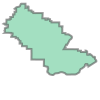

In [11]:
#check if geometry type is Polygon
cf.loc[0, "geometry"]

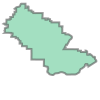

In [12]:
# Save school district shapes, identifiers for use later:
sdshapes = cf["geometry"]
sdid = cf["FIPS"]
sdshapes[0]

In [13]:
sdshapes[:5]

0    POLYGON ((-85.78930799988267 31.49092499996414...
1    POLYGON ((-86.36018100022038 32.39751199946107...
2    (POLYGON ((-86.25092399941492 34.2520789994221...
3    POLYGON ((-89.35270499979971 34.84443199990784...
4    (POLYGON ((-86.16915500020377 34.1865279999401...
Name: geometry, dtype: object

In [14]:
sdid[:5]

0    100001.0
1    100003.0
2    100005.0
3    100006.0
4    100006.0
Name: FIPS, dtype: float64

## Define core function

In [15]:
def mapping_leaid(cord, original):
    '''This method takes in the coordinates of a certain school and search for all 
       school districts to see whether there is a school district contain the coordinates 
       by using Polygon.contains. If so, return the coresponding LEAID else return the 
       original LEAID
       
       Args:
           cord: tuple of lat and long
           original: the original LEAID
       Returns:
           LEAID
    '''
    
    global sdshapes, sdid # School district polygons, identifiers (equivalent to LEAID)
    
    if not cord[0] or not cord[1]:
        return original
    #print("Processing", cord)

    for i in range(len(sdshapes)):
        
#         if cf.loc[i, "FIPS"] == original:
#             print(i)
#             print(cf.loc[i, "FIPS"])
#             print(sdshapes[i].contains(Point((cord[1], cord[0]))))

        #LAT and LONG indeed reversed!
        #fixed below
        if sdshapes[i].contains(Point((cord[1], cord[0]))):
            #print('Find a school district!')
            if sdid.loc[i] != original:
                print(sdid.loc[i], "vs.", original, "- changed!")
                return sdid.loc[i]
            print(sdid.loc[i], "vs.", original)
            return sdid.loc[i]
    return original

In [16]:
#Choose some schools to test differences between original LEAID and newly found LEAID
char_sch.loc[0:100, ['LAT1516', 'LON1516','LEAID']].apply(lambda x: mapping_leaid((x["LAT1516"],x['LON1516']), x['LEAID']), axis=1)

200001.0 vs. 200001.0
200150.0 vs. 200150.0
200150.0 vs. 200150.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200210.0 vs. 200210.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200570.0 vs. 200570.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
400001.0 vs. 400001.0
401460.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
401460.0 vs. 400016.0 - changed!
402860.0 vs. 400018.0 - changed!
402860.0 vs. 400019.0 - changed!
402860.0 vs. 400020.0 - changed!
407240.0 vs. 400028.0 - changed!
407750.0 vs. 400031.0 - changed!
404970.0 vs. 400033.0 - changed!

0           NaN
1      200001.0
2      200150.0
3      200150.0
4      200180.0
5      200180.0
6           NaN
7           NaN
8      200180.0
9      200180.0
10     200180.0
11     200180.0
12     200180.0
13     200180.0
14     200180.0
15     200210.0
16     200390.0
17     200390.0
18     200390.0
19     200390.0
20     200510.0
21     200510.0
22     200510.0
23     200510.0
24          NaN
25     200510.0
26     200510.0
27          NaN
28     200570.0
29     200600.0
         ...   
71          NaN
72          NaN
73          NaN
74          NaN
75          NaN
76          NaN
77     404970.0
78     404970.0
79          NaN
80          NaN
81          NaN
82          NaN
83          NaN
84          NaN
85          NaN
86          NaN
87          NaN
88          NaN
89          NaN
90          NaN
91     407080.0
92          NaN
93          NaN
94          NaN
95     404970.0
96     406810.0
97     404500.0
98          NaN
99          NaN
100    409060.0
Length: 101, dtype: floa

In [17]:
# check randomly picked 401460.0 vs. 400016.0
# The original schools labeled 400016.0
char_sch[char_sch['LEAID'] == 400016.0][['URL','SCH_NAME', 'LAT1516', 'LON1516']]

,URL,SCH_NAME,LAT1516,LON1516
36,https://casschools.com/sierra-vista-campus/,NaN,31.557620,-110.290171
37,https://casschools.com/douglas-campus/,NaN,31.339564,-109.554814
38,https://casschools.com/douglas-campus/,NaN,31.336993,-109.547415
39,https://casschools.com/douglas-campus/,CENTER FOR ACADEMIC SUCCESS #4,31.349052,-109.552012
40,https://casschools.com/sierra-vista-campus/,CENTER FOR ACADEMIC SUCCESS #5,31.557620,-110.290171


In [18]:
#The school district found by our algorithm
cf[cf['FIPS'] == 401460.0]

,FIPS,Name of Area,% Total Population: White Alone,Shape_Leng,Shape_Area,geometry
946,401460.0,"Sierra Vista Unified District, Arizona",79.41,118738.796972,2.801874e+08,POLYGON ((-110.2056699992556 31.64317399947889...


In [19]:
#The school district of the original label 400016.0
cf[cf['FIPS'] == 400016.0]

,FIPS,Name of Area,% Total Population: White Alone,Shape_Leng,Shape_Area,geometry


**_I checked the google map and found that the five schools above are indeed physically in the school district found by our algorithm. But I don't know why our original LEAID (in this case 400016) does not correspond to any school district in the ACS data._**

In [20]:
char_sch[char_sch["LEAID"] == 400016.0][["LEAID", "URL", "LAT1516", "LON1516", "LOCALE15", "ADDRESS16"]]

,LEAID,URL,LAT1516,LON1516,LOCALE15,ADDRESS16
36,400016.0,https://casschools.com/sierra-vista-campus/,31.557620,-110.290171,NaN,"900 Carmelita Drive , Sierra Vista AZ 85635.0"
37,400016.0,https://casschools.com/douglas-campus/,31.339564,-109.554814,NaN,"510 G Avenue , Douglas AZ 85607.0"
38,400016.0,https://casschools.com/douglas-campus/,31.336993,-109.547415,NaN,"919 3rd St. , Douglas AZ 85607.0"
39,400016.0,https://casschools.com/douglas-campus/,31.349052,-109.552012,NaN,"1415 F Avenue , Douglas AZ 85607.0"
40,400016.0,https://casschools.com/sierra-vista-campus/,31.557620,-110.290171,NaN,"900 Carmelita Drive , Sierra Vista AZ 85635.0"


## Run at scale

In [21]:
#Please run again.
#Please run again.
#Please run again.
char_sch['GEO_LEAID'] = char_sch[["LAT1516", 'LON1516','LEAID']].apply(lambda x: mapping_leaid((x["LAT1516"],x['LON1516']), x['LEAID']), axis=1)

200001.0 vs. 200001.0
200150.0 vs. 200150.0
200150.0 vs. 200150.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200180.0 vs. 200180.0
200210.0 vs. 200210.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200390.0 vs. 200390.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200510.0 vs. 200510.0
200570.0 vs. 200570.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
200600.0 vs. 200600.0
400001.0 vs. 400001.0
401460.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
402530.0 vs. 400016.0 - changed!
401460.0 vs. 400016.0 - changed!
402860.0 vs. 400018.0 - changed!
402860.0 vs. 400019.0 - changed!
402860.0 vs. 400020.0 - changed!
407240.0 vs. 400028.0 - changed!
407750.0 vs. 400031.0 - changed!
404970.0 vs. 400033.0 - changed!

409060.0 vs. 400311.0 - changed!
407750.0 vs. 400311.0 - changed!
402690.0 vs. 400311.0 - changed!
401380.0 vs. 400311.0 - changed!
407750.0 vs. 400311.0 - changed!
400960.0 vs. 400311.0 - changed!
407200.0 vs. nan - changed!
402370.0 vs. nan - changed!
408080.0 vs. nan - changed!
409460.0 vs. nan - changed!
408800.0 vs. 400317.0 - changed!
408800.0 vs. 400318.0 - changed!
403870.0 vs. 400320.0 - changed!
403870.0 vs. 400320.0 - changed!
408310.0 vs. 400321.0 - changed!
400680.0 vs. 400322.0 - changed!
404380.0 vs. 400323.0 - changed!
402690.0 vs. 400326.0 - changed!
409060.0 vs. 400327.0 - changed!
407750.0 vs. 400327.0 - changed!
407750.0 vs. 400327.0 - changed!
402370.0 vs. 400328.0 - changed!
401600.0 vs. nan - changed!
403400.0 vs. 400329.0 - changed!
408800.0 vs. 400330.0 - changed!
401680.0 vs. 400332.0 - changed!
409060.0 vs. nan - changed!
402370.0 vs. nan - changed!
403500.0 vs. 400339.0 - changed!
403400.0 vs. 400340.0 - changed!
408800.0 vs. 400343.0 - changed!
408800.0 vs.

406730.0 vs. 400844.0 - changed!
402320.0 vs. 400845.0 - changed!
402320.0 vs. 400845.0 - changed!
408310.0 vs. 400846.0 - changed!
404440.0 vs. 400847.0 - changed!
405930.0 vs. 400848.0 - changed!
407080.0 vs. 400849.0 - changed!
409060.0 vs. 400850.0 - changed!
404380.0 vs. 400851.0 - changed!
404280.0 vs. 400852.0 - changed!
408310.0 vs. 400853.0 - changed!
404720.0 vs. 400854.0 - changed!
401870.0 vs. 400855.0 - changed!
403400.0 vs. 400857.0 - changed!
406300.0 vs. 400858.0 - changed!
403780.0 vs. 400859.0 - changed!
405930.0 vs. 400861.0 - changed!
408800.0 vs. 400862.0 - changed!
407080.0 vs. 400863.0 - changed!
403990.0 vs. 400864.0 - changed!
406250.0 vs. 400866.0 - changed!
401870.0 vs. 400867.0 - changed!
404630.0 vs. 400868.0 - changed!
404500.0 vs. nan - changed!
404290.0 vs. 400871.0 - changed!
408800.0 vs. 400872.0 - changed!
405930.0 vs. 400873.0 - changed!
400680.0 vs. 400874.0 - changed!
405670.0 vs. 400875.0 - changed!
407080.0 vs. 400876.0 - changed!
404500.0 vs. 40

635790.0 vs. 601950.0 - changed!
641160.0 vs. 602010.0 - changed!
634320.0 vs. nan - changed!
602310.0 vs. 602310.0
602310.0 vs. 602310.0
602310.0 vs. 602310.0
602310.0 vs. 602310.0
602310.0 vs. 602310.0
602370.0 vs. 602370.0
602610.0 vs. 602610.0
607680.0 vs. 602700.0 - changed!
620880.0 vs. 602820.0 - changed!
615240.0 vs. 602820.0 - changed!
642120.0 vs. 602820.0 - changed!
602850.0 vs. 602850.0
602850.0 vs. 602850.0
603000.0 vs. 603000.0
603000.0 vs. 603000.0
603000.0 vs. 603000.0
603000.0 vs. 603000.0
603000.0 vs. 603030.0 - changed!
603030.0 vs. 603030.0
603090.0 vs. 603090.0
616470.0 vs. 603180.0 - changed!
636840.0 vs. 603180.0 - changed!
641190.0 vs. nan - changed!
603480.0 vs. 603480.0
603480.0 vs. 603480.0
629940.0 vs. 603690.0 - changed!
629940.0 vs. 603690.0 - changed!
603870.0 vs. 603870.0
603870.0 vs. 603870.0
604080.0 vs. 604080.0
604290.0 vs. 604290.0
604380.0 vs. 604380.0
604740.0 vs. 604740.0
604740.0 vs. 604740.0
605240.0 vs. 605240.0
605580.0 vs. 605280.0 - changed

622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 vs. 622710.0
622710.0 v

629490.0 vs. 629490.0
629490.0 vs. 629490.0
629490.0 vs. 629490.0
629490.0 vs. 629490.0
629550.0 vs. 629550.0
629580.0 vs. 629580.0
629580.0 vs. 629580.0
629580.0 vs. 629580.0
629790.0 vs. 629790.0
629820.0 vs. 629820.0
629820.0 vs. 629820.0
629820.0 vs. 629820.0
629820.0 vs. 629820.0
629820.0 vs. 629820.0
629940.0 vs. 629940.0
629940.0 vs. 629940.0
629940.0 vs. 629940.0
629940.0 vs. 629940.0
629940.0 vs. 629940.0
630030.0 vs. 630030.0
630180.0 vs. 630180.0
630180.0 vs. 630210.0 - changed!
630230.0 vs. 630230.0
630230.0 vs. 630230.0
630230.0 vs. 630230.0
630230.0 vs. 630250.0 - changed!
628320.0 vs. 630250.0 - changed!
630230.0 vs. 630250.0 - changed!
630450.0 vs. 630450.0
630450.0 vs. 630450.0
630450.0 vs. 630450.0
630450.0 vs. 630450.0
616500.0 vs. 630510.0 - changed!
616500.0 vs. 630510.0 - changed!
616500.0 vs. 630510.0 - changed!
630720.0 vs. 630720.0
630990.0 vs. 630990.0
630990.0 vs. 630990.0
631170.0 vs. 631170.0
631320.0 vs. 631320.0
631320.0 vs. 631320.0
609030.0 vs. 631680.0

603630.0 vs. 691012.0 - changed!
610890.0 vs. 691012.0 - changed!
603270.0 vs. 691012.0 - changed!
623340.0 vs. 691017.0 - changed!
623340.0 vs. 691017.0 - changed!
611220.0 vs. 691018.0 - changed!
624600.0 vs. 691020.0 - changed!
633930.0 vs. 691021.0 - changed!
629370.0 vs. 691021.0 - changed!
625530.0 vs. 691021.0 - changed!
633930.0 vs. 691021.0 - changed!
615780.0 vs. 691023.0 - changed!
626820.0 vs. 691023.0 - changed!
630930.0 vs. 691023.0 - changed!
626820.0 vs. 691023.0 - changed!
615780.0 vs. 691023.0 - changed!
615780.0 vs. 691023.0 - changed!
626820.0 vs. 691023.0 - changed!
638880.0 vs. 691023.0 - changed!
614880.0 vs. 691024.0 - changed!
635310.0 vs. 691024.0 - changed!
640150.0 vs. 691024.0 - changed!
609300.0 vs. 691025.0 - changed!
603480.0 vs. 691025.0 - changed!
600028.0 vs. 691026.0 - changed!
609070.0 vs. 691026.0 - changed!
625800.0 vs. 691026.0 - changed!
633150.0 vs. 691026.0 - changed!
633150.0 vs. 691026.0 - changed!
612330.0 vs. 691027.0 - changed!
634170.0 v

804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804800.0 vs. 804800.0
804830.0 vs. 804830.0
804920.0 vs. 804920.0
805220.0 vs. 805220.0
805310.0 vs. 805310.0
805310.0 vs. 805310.0
805370.0 vs. 805370.0
805370.0 vs. 805370.0
805370.0 vs. 805370.0
805370.0 vs. 805370.0
805370.0 vs. 805370.0
805370.0 vs. 805370.0
805400.0 vs. 805400.0
805400.0 vs. 805400.0
805700.0 vs. 805700.0
805790.0 vs. 805790.0
805790.0 vs. 805790.0
805820.0 vs. 805820.0
805850.0 vs. 805850.0
803060.0 vs. 806060.0 - changed!
806120.0 vs. 806120.0
806120.0 vs. 806120.0
806120.0 vs. 806150.0 - changed!
806150.0 vs. 806150.0
806150.0 vs. 806150.0
806480.0 vs. 806480.0
806660.0 vs. 806660.0
806750.0 vs. 806750.0
806900.0 vs. 806900.0
806900.0 vs. 806900.0
806900.0 vs. 806900.0
806900.0 vs. 806900.0
807350.0 vs. 807350.0
807350.0 vs. 807350.0
901920.0 vs. 900007.0 - changed!

1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 1200180.0
1200180.0 vs. 12

1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. nan - changed!
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. nan - changed!
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200870.0 vs. 1200870.0
1200480.0 vs. 1200870.0 - changed!
1200870.0 vs. 1200870.0
1200870.0 vs. nan - changed!
1200870.0 vs. 1200870.0
1200870.0 vs. nan - changed!
1200870.0 vs. 1200870.0
1200870.0 vs. nan - changed!
1200870.0 vs. nan - changed!
1200930.0 vs. 1200930.0
1200930.0 vs. 1200930.0
1200930.0 vs. 1200930.0
1200930.0 vs. 1200930.0
1200930.0 vs. 1200930.0
1201050.0 vs. 1201050.0
1201050.0 vs. 1201050.0
1201050.0 vs. 1201050.0
1201050.0 vs. 1201050.0

1201920.0 vs. 1201920.0
1201920.0 vs. 1201920.0
1201950.0 vs. 1201950.0
1201980.0 vs. 1201980.0
1201980.0 vs. 1201980.0
1201980.0 vs. 1201980.0
1201770.0 vs. 1202012.0 - changed!
1201110.0 vs. 1202013.0 - changed!
1200180.0 vs. 1202013.0 - changed!
1300630.0 vs. 1300005.0 - changed!
1301500.0 vs. 1300023.0 - changed!
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. nan - changed!
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1300120.0 vs. 1300120.0
1305670.0 vs. 1300214.0 - changed!
1302550.0 vs. 1300215.0 - changed!
1302280.0 vs. 1300217.0 - changed!
100540.0 vs. 1300218.0 - changed!
1300120.0 vs. 1300221.0 - changed!
1301500.0 vs. 1300222.0 - changed!
101140.0 vs. 1300226.0 - changed!
1302550.0 vs. 1300227.0 - changed!
101140.0 vs. 1300229.0 - changed!
1006

1800150.0 vs. 1800077.0 - changed!
1812360.0 vs. 1800081.0 - changed!
1804320.0 vs. 1800082.0 - changed!
1800630.0 vs. 1800083.0 - changed!
1804770.0 vs. 1800084.0 - changed!
1804770.0 vs. 1800086.0 - changed!
1810290.0 vs. 1800087.0 - changed!
1802800.0 vs. 1800088.0 - changed!
1804770.0 vs. nan - changed!
1804770.0 vs. 1800093.0 - changed!
1812720.0 vs. 1800094.0 - changed!
1804770.0 vs. nan - changed!
1808910.0 vs. 1800098.0 - changed!
1809370.0 vs. 1800099.0 - changed!
1810290.0 vs. 1800101.0 - changed!
1803870.0 vs. 1800102.0 - changed!
1801200.0 vs. 1800106.0 - changed!
1802640.0 vs. 1800108.0 - changed!
1809150.0 vs. 1800113.0 - changed!
1800270.0 vs. nan - changed!
1800150.0 vs. 1800116.0 - changed!
1803630.0 vs. 1800121.0 - changed!
1804770.0 vs. 1800122.0 - changed!
1807320.0 vs. 1800123.0 - changed!
1804770.0 vs. 1800124.0 - changed!
1804770.0 vs. 1800125.0 - changed!
1804770.0 vs. 1800128.0 - changed!
1806120.0 vs. 1800129.0 - changed!
1803630.0 vs. 1800131.0 - changed!
180

2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400510.0 vs. 2400510.0
2400600.0 vs. 2400600.0
2502790.0 vs. 2500021.0 - changed!
2503270.0 vs. 2500022.0 - changed!
2500544.0 vs. 2500024.0 - changed!
2511760.0 vs. 2500025.0 - changed!
2502790.0 vs. 2500026.0 - changed!
2506660.0 vs. 2500027.0 - changed!
2511130.0 vs. 2500028.0 - changed!
2502790.0 vs. 2500029.0 - changed!
2505010.0 vs. 2500030.0 - changed!
2504590.0 vs. 2500031.0 - changed!
2506660.0 vs. 2500032.0 - changed!
2507020.0 vs. 2500033.0 - changed!
2507260.0 vs. 2500034.0 - changed!
2500043.0 vs. 2500035.0 - changed!
2500542.0 vs. 2500038.0 - changed!
2502790.0 vs. 2500039.0 - changed!
2509030.0 vs. 2500040.0 - changed!
2504830.0 vs. 2500041.0 - changed!
2510920.0 vs. 2500044.0 - changed!
2513230.0 vs. 2500045.0 - changed!
2503270.0 vs. 2500046.0 - changed!
2

2612000.0 vs. 2600242.0 - changed!
2612000.0 vs. 2600243.0 - changed!
2612000.0 vs. 2600244.0 - changed!
2612000.0 vs. 2600244.0 - changed!
2611600.0 vs. 2600245.0 - changed!
2636630.0 vs. 2600248.0 - changed!
2618330.0 vs. 2600249.0 - changed!
2618330.0 vs. 2600249.0 - changed!
2622970.0 vs. 2600250.0 - changed!
2603540.0 vs. 2600251.0 - changed!
2616440.0 vs. 2600252.0 - changed!
2628740.0 vs. 2600254.0 - changed!
2611600.0 vs. 2600255.0 - changed!
2602190.0 vs. nan - changed!
2630120.0 vs. 2600262.0 - changed!
2628560.0 vs. 2600263.0 - changed!
2604260.0 vs. 2600264.0 - changed!
2633870.0 vs. 2600265.0 - changed!
2628740.0 vs. 2600267.0 - changed!
2626400.0 vs. 2600269.0 - changed!
2632340.0 vs. 2600270.0 - changed!
2612000.0 vs. 2600271.0 - changed!
2612000.0 vs. 2600272.0 - changed!
2612000.0 vs. 2600272.0 - changed!
2612000.0 vs. 2600272.0 - changed!
2612000.0 vs. 2600272.0 - changed!
2612000.0 vs. 2600272.0 - changed!
2614820.0 vs. 2600273.0 - changed!
2602220.0 vs. 2600274.0 - 

2624840.0 vs. 2601088.0 - changed!
2628560.0 vs. 2601089.0 - changed!
2628830.0 vs. 2601090.0 - changed!
2629460.0 vs. 2601091.0 - changed!
2635850.0 vs. 2601092.0 - changed!
2630990.0 vs. nan - changed!
2619950.0 vs. nan - changed!
2620160.0 vs. 2601095.0 - changed!
2628140.0 vs. 2601096.0 - changed!
2623130.0 vs. nan - changed!
2615450.0 vs. 2601098.0 - changed!
2619950.0 vs. nan - changed!
2622290.0 vs. 2601100.0 - changed!
2612000.0 vs. nan - changed!
2721240.0 vs. 2700027.0 - changed!
2733840.0 vs. 2700028.0 - changed!
2718070.0 vs. 2700092.0 - changed!
2718070.0 vs. 2700092.0 - changed!
2703180.0 vs. 2700093.0 - changed!
2703180.0 vs. 2700093.0 - changed!
2725200.0 vs. 2700096.0 - changed!
2733840.0 vs. 2700115.0 - changed!
2733840.0 vs. 2700115.0 - changed!
2708190.0 vs. 2700116.0 - changed!
2721240.0 vs. 2700117.0 - changed!
2721240.0 vs. 2700117.0 - changed!
2721240.0 vs. 2700117.0 - changed!
2733840.0 vs. 2700117.0 - changed!
2721240.0 vs. 2700117.0 - changed!
2721240.0 vs. 2

2733840.0 vs. 2700415.0 - changed!
2733840.0 vs. nan - changed!
2721240.0 vs. nan - changed!
2733840.0 vs. nan - changed!
2725200.0 vs. nan - changed!
2723850.0 vs. nan - changed!
2715030.0 vs. nan - changed!
2711040.0 vs. nan - changed!
2744070.0 vs. 2705850.0 - changed!
2733840.0 vs. 2708955.0 - changed!
2738190.0 vs. 2723380.0 - changed!
2802190.0 vs. 2800188.0 - changed!
2802190.0 vs. 2800190.0 - changed!
2916400.0 vs. 2900011.0 - changed!
2916400.0 vs. 2900013.0 - changed!
2916400.0 vs. 2900013.0 - changed!
2916400.0 vs. 2900014.0 - changed!
2916400.0 vs. 2900014.0 - changed!
2916400.0 vs. 2900014.0 - changed!
2916400.0 vs. 2900015.0 - changed!
2916400.0 vs. 2900016.0 - changed!
2916400.0 vs. 2900017.0 - changed!
2916400.0 vs. 2900017.0 - changed!
2916400.0 vs. 2900019.0 - changed!
2916400.0 vs. 2900024.0 - changed!
2916400.0 vs. 2900024.0 - changed!
2916400.0 vs. 2900025.0 - changed!
2916400.0 vs. 2900025.0 - changed!
2916400.0 vs. 2900027.0 - changed!
2916400.0 vs. 2900027.0 - c

3411340.0 vs. 3400760.0 - changed!
3402640.0 vs. 3400762.0 - changed!
3402640.0 vs. 3400763.0 - changed!
3411340.0 vs. 3400764.0 - changed!
3412690.0 vs. 3400765.0 - changed!
3416800.0 vs. 3400766.0 - changed!
3407830.0 vs. 3400767.0 - changed!
3402640.0 vs. 3400768.0 - changed!
3404920.0 vs. 3400770.0 - changed!
3400960.0 vs. 3400771.0 - changed!
3411340.0 vs. 3400773.0 - changed!
3407830.0 vs. 3400774.0 - changed!
3416290.0 vs. 3400775.0 - changed!
3413140.0 vs. 3400779.0 - changed!
3407830.0 vs. 3400781.0 - changed!
3402250.0 vs. 3400782.0 - changed!
3413200.0 vs. 3400783.0 - changed!
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060.0
3500060.0 vs. 3500060

3620580.0 vs. 3601005.0 - changed!
3602460.0 vs. 3601006.0 - changed!
3624750.0 vs. 3601008.0 - changed!
3620580.0 vs. 3601009.0 - changed!
3620580.0 vs. 3601010.0 - changed!
3620580.0 vs. 3601011.0 - changed!
3620580.0 vs. 3601012.0 - changed!
3620580.0 vs. 3601013.0 - changed!
3620580.0 vs. 3601014.0 - changed!
3620580.0 vs. 3601015.0 - changed!
3620580.0 vs. 3601016.0 - changed!
3620580.0 vs. 3601017.0 - changed!
3620580.0 vs. 3601018.0 - changed!
3620580.0 vs. 3601019.0 - changed!
3602460.0 vs. nan - changed!
3602460.0 vs. nan - changed!
3605850.0 vs. 3601022.0 - changed!
3620580.0 vs. 3601023.0 - changed!
3620580.0 vs. 3601024.0 - changed!
3620580.0 vs. 3601025.0 - changed!
3620580.0 vs. 3601027.0 - changed!
3620580.0 vs. 3601028.0 - changed!
3620580.0 vs. 3601029.0 - changed!
3620580.0 vs. 3601030.0 - changed!
3620580.0 vs. 3601031.0 - changed!
3620580.0 vs. 3601032.0 - changed!
3620580.0 vs. 3601033.0 - changed!
3620580.0 vs. 3601034.0 - changed!
3620580.0 vs. 3601035.0 - change

3703330.0 vs. 3700332.0 - changed!
3702970.0 vs. 3700333.0 - changed!
3703780.0 vs. 3700334.0 - changed!
3700960.0 vs. nan - changed!
3701800.0 vs. 3700336.0 - changed!
3704720.0 vs. 3700337.0 - changed!
3701800.0 vs. 3700338.0 - changed!
3702970.0 vs. 3700339.0 - changed!
3703330.0 vs. 3700340.0 - changed!
3700750.0 vs. 3700341.0 - changed!
3701500.0 vs. 3700343.0 - changed!
3701920.0 vs. 3700344.0 - changed!
3703930.0 vs. 3700346.0 - changed!
3700530.0 vs. 3700347.0 - changed!
3703450.0 vs. 3700348.0 - changed!
3700960.0 vs. 3700349.0 - changed!
3702970.0 vs. 3700350.0 - changed!
3700390.0 vs. 3700351.0 - changed!
3701260.0 vs. 3700352.0 - changed!
3700900.0 vs. 3700353.0 - changed!
3703480.0 vs. 3700354.0 - changed!
3702970.0 vs. 3700356.0 - changed!
3702970.0 vs. 3700357.0 - changed!
3704720.0 vs. 3700358.0 - changed!
3702970.0 vs. 3700359.0 - changed!
3700450.0 vs. 3700361.0 - changed!
3704720.0 vs. 3700362.0 - changed!
3701260.0 vs. 3700363.0 - changed!
3704720.0 vs. 3700364.0 - 

3904490.0 vs. 3901339.0 - changed!
3904380.0 vs. 3901344.0 - changed!
3904380.0 vs. 3901345.0 - changed!
3904490.0 vs. 3901346.0 - changed!
3904384.0 vs. 3901347.0 - changed!
3910027.0 vs. 3901348.0 - changed!
3904350.0 vs. 3901350.0 - changed!
3904380.0 vs. 3901353.0 - changed!
3904380.0 vs. 3901354.0 - changed!
3904844.0 vs. 3901356.0 - changed!
3910023.0 vs. 3901359.0 - changed!
3904919.0 vs. nan - changed!
3904490.0 vs. 3901362.0 - changed!
3904524.0 vs. 3901363.0 - changed!
3904426.0 vs. 3901365.0 - changed!
3904384.0 vs. 3901366.0 - changed!
3904378.0 vs. 3901368.0 - changed!
3904378.0 vs. 3901370.0 - changed!
3904842.0 vs. 3901372.0 - changed!
3904380.0 vs. 3901375.0 - changed!
3904378.0 vs. 3901376.0 - changed!
3904348.0 vs. 3901377.0 - changed!
3904700.0 vs. 3901378.0 - changed!
3904429.0 vs. 3901381.0 - changed!
3904380.0 vs. 3901382.0 - changed!
3904384.0 vs. 3901383.0 - changed!
3904516.0 vs. 3901389.0 - changed!
3904697.0 vs. 3901393.0 - changed!
3904380.0 vs. 3901396.0 - 

4106000.0 vs. 4106000.0
4106120.0 vs. 4106120.0
4106600.0 vs. 4106600.0
4106630.0 vs. 4106630.0
4106870.0 vs. 4106870.0
4106900.0 vs. 4106900.0
4106900.0 vs. 4106900.0
4107020.0 vs. 4107020.0
4107080.0 vs. 4107080.0
4107380.0 vs. 4107380.0
1303330.0 vs. 4107500.0 - changed!
1303330.0 vs. 4107500.0 - changed!
1303330.0 vs. 4107500.0 - changed!
1303330.0 vs. 4107500.0 - changed!
4107590.0 vs. 4107590.0
4108040.0 vs. 4108040.0
4108040.0 vs. 4108040.0
4108040.0 vs. 4108040.0
4108040.0 vs. 4108040.0
4108100.0 vs. 4108100.0
4108280.0 vs. 4108280.0
4108310.0 vs. 4108310.0
4108310.0 vs. 4108310.0
4108820.0 vs. 4108820.0
4108820.0 vs. 4108820.0
4108820.0 vs. 4108820.0
4108830.0 vs. 4108830.0
4108830.0 vs. 4108830.0
4108830.0 vs. 4108830.0
4108830.0 vs. 4108830.0
4108940.0 vs. 4108940.0
4109330.0 vs. 4109330.0
4109330.0 vs. 4109330.0
4109330.0 vs. 4109330.0
4109330.0 vs. 4109330.0
4109430.0 vs. 4109430.0
4109510.0 vs. 4109510.0
4109600.0 vs. 4109600.0
4109630.0 vs. 4109630.0
4109720.0 vs. 410972

4211580.0 vs. 4200876.0 - changed!
4218990.0 vs. 4200877.0 - changed!
4202280.0 vs. 4200879.0 - changed!
4219170.0 vs. 4200880.0 - changed!
4202280.0 vs. 4200881.0 - changed!
4219170.0 vs. 4200882.0 - changed!
4202280.0 vs. 4200883.0 - changed!
4214940.0 vs. 4200884.0 - changed!
4226390.0 vs. 4200885.0 - changed!
4218990.0 vs. 4200886.0 - changed!
4400120.0 vs. 4400006.0 - changed!
4401200.0 vs. 4400008.0 - changed!
4401200.0 vs. 4400008.0 - changed!
4400120.0 vs. 4400014.0 - changed!
4400270.0 vs. 4400015.0 - changed!
4400120.0 vs. 4400015.0 - changed!
4400270.0 vs. 4400015.0 - changed!
4400270.0 vs. 4400015.0 - changed!
508940.0 vs. 4400015.0 - changed!
4400360.0 vs. 4400017.0 - changed!
4400900.0 vs. 4400018.0 - changed!
4400900.0 vs. 4400019.0 - changed!
4400900.0 vs. 4400021.0 - changed!
4400900.0 vs. 4400021.0 - changed!
4400900.0 vs. 4400024.0 - changed!
4400120.0 vs. 4400024.0 - changed!
4400900.0 vs. 4400025.0 - changed!
4400900.0 vs. 4400027.0 - changed!
4400900.0 vs. 4400028

4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4824420.0 vs. 4800030.0 - changed!
4808700.0 vs. 4800030.0 - changed!
4808700.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4819700.0 vs. 4800030.0 - changed!
4819700.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4824420.0 vs. 4800030.0 - changed!
4824420.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4821420.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4816230.0 vs. 4800030.0 - changed!
4823640.0 vs. 4800031.0 - changed!
4823640.0 vs. 4800032.0 - changed!
4843470.0 vs. 4800034.0 - changed!
4843470.0 vs. 4800034.0 - changed!
4845600.0 vs. 4800034.0 - changed!
4807830.0 vs. 4800035.0 - changed!
4845780.0 vs. nan - changed!
4818300.0 vs. 4800037.0 - changed!
4818300.0 vs. 4800037.0 - 

4808700.0 vs. 4800158.0 - changed!
4808700.0 vs. 4800158.0 - changed!
4841520.0 vs. 4800159.0 - changed!
4842060.0 vs. 4800159.0 - changed!
4824030.0 vs. 4800163.0 - changed!
4827300.0 vs. 4800163.0 - changed!
4816230.0 vs. 4800163.0 - changed!
4812810.0 vs. 4800163.0 - changed!
4826430.0 vs. 4800163.0 - changed!
4815210.0 vs. 4800163.0 - changed!
4827300.0 vs. 4800163.0 - changed!
4813050.0 vs. 4800163.0 - changed!
4845900.0 vs. 4800163.0 - changed!
4820340.0 vs. 4800163.0 - changed!
4824630.0 vs. 4800163.0 - changed!
4827300.0 vs. 4800163.0 - changed!
4817640.0 vs. 4800163.0 - changed!
4832940.0 vs. 4800163.0 - changed!
4827300.0 vs. 4800163.0 - changed!
4826430.0 vs. 4800163.0 - changed!
4823640.0 vs. nan - changed!
4808940.0 vs. 4800163.0 - changed!
4818180.0 vs. 4800163.0 - changed!
4809670.0 vs. 4800163.0 - changed!
4815720.0 vs. 4800163.0 - changed!
4818360.0 vs. 4800163.0 - changed!
4813050.0 vs. 4800163.0 - changed!
4816860.0 vs. nan - changed!
4843470.0 vs. 4800163.0 - change

4827870.0 vs. 4800259.0 - changed!
4815270.0 vs. 4800259.0 - changed!
4843470.0 vs. 4800259.0 - changed!
4816230.0 vs. 4800260.0 - changed!
4816230.0 vs. 4800260.0 - changed!
4816230.0 vs. 4800260.0 - changed!
4823640.0 vs. 4800262.0 - changed!
4823640.0 vs. 4800263.0 - changed!
4823640.0 vs. 4800263.0 - changed!
4823640.0 vs. 4800263.0 - changed!
4828890.0 vs. 4800264.0 - changed!
4828890.0 vs. 4800264.0 - changed!
4828890.0 vs. 4800264.0 - changed!
4828890.0 vs. 4800264.0 - changed!
4828890.0 vs. 4800264.0 - changed!
4808940.0 vs. 4800264.0 - changed!
4808940.0 vs. 4800264.0 - changed!
4808940.0 vs. 4800264.0 - changed!
4808940.0 vs. 4800264.0 - changed!
4828890.0 vs. 4800265.0 - changed!
4826790.0 vs. 4800266.0 - changed!
4811680.0 vs. 4800266.0 - changed!
4832940.0 vs. 4800266.0 - changed!
4843650.0 vs. 4800266.0 - changed!
4817850.0 vs. 4800268.0 - changed!
4838730.0 vs. 4800268.0 - changed!
4838730.0 vs. 4800268.0 - changed!
4816230.0 vs. nan - changed!
4816230.0 vs. 4800270.0 - 

4900420.0 vs. 4900034.0 - changed!
4900330.0 vs. 4900035.0 - changed!
4900360.0 vs. 4900036.0 - changed!
4900390.0 vs. 4900037.0 - changed!
2931110.0 vs. 4900037.0 - changed!
4900030.0 vs. 4900038.0 - changed!
4900120.0 vs. 4900039.0 - changed!
4900142.0 vs. 4900040.0 - changed!
4900360.0 vs. 4900041.0 - changed!
4900360.0 vs. 4900041.0 - changed!
4900210.0 vs. 4900042.0 - changed!
4900030.0 vs. 4900042.0 - changed!
4900030.0 vs. 4900043.0 - changed!
4900210.0 vs. 4900044.0 - changed!
4900210.0 vs. 4900044.0 - changed!
4900210.0 vs. 4900045.0 - changed!
2931110.0 vs. 4900046.0 - changed!
4900630.0 vs. 4900047.0 - changed!
4900030.0 vs. 4900048.0 - changed!
4900360.0 vs. 4900049.0 - changed!
4900870.0 vs. 4900050.0 - changed!
4900030.0 vs. 4900051.0 - changed!
4900420.0 vs. 4900052.0 - changed!
4900030.0 vs. 4900056.0 - changed!
4900720.0 vs. 4900058.0 - changed!
4900810.0 vs. 4900061.0 - changed!
4900810.0 vs. 4900062.0 - changed!
4900810.0 vs. nan - changed!
4900210.0 vs. 4900063.0 - 

5509600.0 vs. nan - changed!
5509600.0 vs. 5509600.0
5509600.0 vs. 5509600.0
5509690.0 vs. 5509690.0
5509690.0 vs. 5509690.0
5509720.0 vs. 5509720.0
5509720.0 vs. 5509720.0
5509720.0 vs. 5509720.0
5509720.0 vs. 5509720.0
5509810.0 vs. 5509810.0
5509870.0 vs. 5509870.0
5509870.0 vs. 5509870.0
5509870.0 vs. 5509870.0
5509870.0 vs. 5509870.0
5510060.0 vs. 5510060.0
5510320.0 vs. 5510320.0
5510380.0 vs. 5510380.0
5510380.0 vs. 5510380.0
5510230.0 vs. 5510560.0 - changed!
902820.0 vs. 5510590.0 - changed!
902820.0 vs. 5510590.0 - changed!
5510620.0 vs. 5510620.0
5510920.0 vs. nan - changed!
5510920.0 vs. 5510920.0
5510950.0 vs. 5510950.0
5510950.0 vs. 5510950.0
510950.0 vs. 5511160.0 - changed!
5511190.0 vs. 5511190.0
5511190.0 vs. 5511190.0
5512060.0 vs. 5512060.0
5512150.0 vs. 5512150.0
5512360.0 vs. 5512360.0
5512360.0 vs. 5512360.0
5512720.0 vs. 5512720.0
5512720.0 vs. 5512720.0
5512810.0 vs. 5512810.0
4220250.0 vs. 5512960.0 - changed!
5513020.0 vs. 5513020.0
5513020.0 vs. 5513020.0
55

In [22]:
# Check out the resulting DF:
print(char_sch[["LAT1516","LON1516", "LEAID", "GEO_LEAID"]].isna().apply(sum))
char_sch[["LAT1516","LON1516", "LEAID", "GEO_LEAID"]]

LAT1516      3613
LON1516      3613
LEAID        4016
GEO_LEAID    3612
dtype: int64


,LAT1516,LON1516,LEAID,GEO_LEAID
0,NaN,NaN,NaN,NaN
1,60.796131,-161.765194,200001.0,200001.0
2,55.347001,-131.641191,200150.0,200150.0
3,55.347001,-131.641191,200150.0,200150.0
4,61.192407,-149.916872,200180.0,200180.0
5,61.198100,-149.876000,200180.0,200180.0
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,61.194450,-149.791641,200180.0,200180.0
9,61.319213,-149.579442,200180.0,200180.0


In [25]:
len(char_sch[char_sch['LEAID'] != char_sch['GEO_LEAID']])

8346

In [27]:
len(char_sch[char_sch['LEAID'] == char_sch['GEO_LEAID']])

2619

In [30]:
len(char_sch[char_sch['GEO_LEAID'].isnull()])

3612

In [31]:
len(char_sch[char_sch['LEAID'].isnull()])

4016

In [37]:
a =char_sch[char_sch['GEO_LEAID'].isnull()]

In [38]:
len(a[a["LAT1516"].isnull()])

3612

### Save modified data to disk

In [36]:
char_sch.to_pickle("../../nowdata/backups/charters_full_2015_250_v2a_unlappedtext_counts3_geoleaid.pkl")

## Prep for multiprocessing (probably not necessary)

In [ ]:
# Import packages for multiprocessing
!pip install tqdm # for monitoring progress of multiprocessing
numcpus = len(os.sched_getaffinity(0)) # Detect and assign number of available CPUs
from multiprocessing import Pool # key function for multiprocessing, to increase processing speed
pool = Pool(processes=numcpus) # Pre-load number of CPUs into pool function

In [24]:
tuplist = [tuple(x) for x in char_sch[["NCESSCH", "LAT1516", "LON1516", "LEAID"]].values]
tuplist

[(10019702432.0, nan, nan, nan),
 (20000100329.0, 60.796131000000003, -161.76519400000001, 200001.0),
 (20015000306.0, 55.347000999999999, -131.64119099999999, 200150.0),
 (20015000523.0, 55.347000999999999, -131.64119099999999, 200150.0),
 (20018000172.0, 61.192407000000003, -149.91687200000001, 200180.0),
 (20018000178.0, 61.198099999999997, -149.876, 200180.0),
 (20018000228.0, nan, nan, nan),
 (20018000315.0, nan, nan, nan),
 (20018000459.0, 61.194450000000003, -149.791641, 200180.0),
 (20018000460.0, 61.319212999999998, -149.579442, 200180.0),
 (20018000530.0, 61.194913999999997, -149.891223, 200180.0),
 (20018000555.0, 61.193958000000002, -149.77575899999999, 200180.0),
 (20018000732.0, 61.173153999999997, -149.89561599999999, 200180.0),
 (20018000736.0, 61.217660000000002, -149.81042099999999, 200180.0),
 (20018000756.0, 61.21264, -149.894621, 200180.0),
 (20021000268.0, 58.302779999999998, -134.407219, 200210.0),
 (20039000274.0, 60.554091, -151.254006, 200390.0),
 (20039000296

In [ ]:
# Use multiprocessing.Pool(numcpus) to run your function:
print("Matching schools with LEAID based on LAT/LON coordinates:
if __name__ == '__main__':
    with Pool(numcpus) as p:
        p.map(mapping_leaid(), tqdm(tuplist, desc="Matching LAT/LON to LEAID")) 